# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [76]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import sys
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine nearest city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [84]:
# This list of cities is randomly distributed by latitude and longitude
# To generate:
#     Generate a list of random locations, by latitude and longitude
#     Find the city nearest each random location
# Since it is possible for random locations to be nearest the same city,
# especially in the oceanic and polar regions, generate a large number
# of random locations; large enough to generate 500+ random cities.
SAMPLE_SIZE = 1500

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=SAMPLE_SIZE)
lngs = np.random.uniform(low=-180.000, high=180.000, size=SAMPLE_SIZE)

# Allocate space for the city and country names of the random cities (faster than append)
city_names = [None]*SAMPLE_SIZE
country_codes = [None]*SAMPLE_SIZE

# Identify nearest city for each lat, lng combination
for iRow in range(SAMPLE_SIZE):
    #print(iRow)
    city = citipy.nearest_city(lats[iRow], lngs[iRow])
    city_names[iRow] = city.city_name
    country_codes[iRow] = city.country_code

# Create a DataFrame of the random locations, and drop duplicates
random_cities = pd.DataFrame({"city_name" : city_names, "country_code" : country_codes}).drop_duplicates(ignore_index=True)

In [85]:
ow_cities = pd.read_json('city.list.json')[["id", "name", "country"]]
ow_cities["name"] = ow_cities["name"].str.lower()
ow_cities["country"] = ow_cities["country"].str.lower()

In [88]:
# For efficiency, use the Open Weather Group API

# The Group API requires location IDs.  
# At http://bulk.openweathermap.org/sample/, Open Weather provides a JSON list of cities and IDs
# Read the city list into a DataFrame
ow_cities = pd.read_json('city.list.json')[["id", "name", "country"]]

# The citipy module provided lowercase city and country names.  Change this DataFrame to match.
ow_cities["name"] = ow_cities["name"].str.lower()
ow_cities["country"] = ow_cities["country"].str.lower()


temp = random_cities.merge(ow_cities, left_on=("city_name","country_code"), right_on=("name","country"))
cities_with_id = pd.pivot_table(temp, values="id", index=['name', 'country'], aggfunc="min").reset_index()
cities_with_id

,name,country,id
0,aasiaat,gl,3424901
1,adrar,dz,2508813
2,agadir,ma,2561668
3,aguimes,es,2522325
4,aklavik,ca,5882953
...,...,...,...
501,zamora,ec,3649959
502,zhigansk,ru,2012530
503,ziro,in,1252668
504,zwedru,lr,2272491


In [184]:
# The Group API handles up to twenty city IDs simultaneously
MAX_GROUP_SIZE = 20

city_ids = cities_with_id["id"].astype(str)
city_ids.size

result_list = list()
for i in range(0,city_ids.size,20):
    ids = ",".join(city_ids[i:min(i+MAX_GROUP_SIZE,city_ids.size)])
    #print (f"select indexes from {i} to {min(i+20,506)}")
    #print(ids)
    url = f"http://api.openweathermap.org/data/2.5/group?id={ids}&units=imperial&appid={weather_api_key}"
    result_list += requests.get(url).json()['list']   

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [185]:
city_weather = pd.json_normalize(result_list) \
    [["id","name","sys.country","coord.lat","coord.lon","dt","main.temp_max","wind.speed","clouds.all","main.humidity"]] \
    .rename(columns={"id":"City_ID","name":"City","sys.country":"Country","coord.lon":"Lng","coord.lat":"Lat","dt":"Date",
             "main.temp_max":"Max_Temp","wind.speed":"Wind_Speed","clouds.all":"Cloudiness","main.humidity":"Humidity"}
    )

city_weather.to_csv(output_data_file, index=False)

In [186]:
city_weather.columns

Index(['City_ID', 'City', 'Country', 'Lat', 'Lng', 'Date', 'Max_Temp',
       'Wind_Speed', 'Cloudiness', 'Humidity'],
      dtype='object')

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [196]:
def plot_metric_against_latitude(figure_number, df, y_column, y_label, title_label):
    fig = plt.figure(figure_number)
    weather_date = time.strftime("%d %b %Y", time.localtime(df["Date"][0]))
    plt.scatter(x=df["Lat"],y=df[y_column])
    plt.grid()
    plt.xlabel("Latitude")
    plt.ylabel(y_label)
    plt.title(f"{title_label} v. Latitude ({weather_date})")
    plt.savefig(f"output_data/Figure{figure_number}.png")
    return fig

#### Latitude vs. Temperature Plot

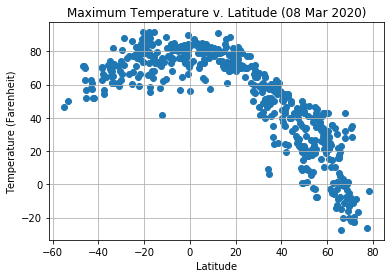

In [197]:
fig = plot_metric_against_latitude(1, city_weather, "Max_Temp", "Temperature (Farenheit)", "Maximum Temperature")

In [199]:
plt.close(fig)

#### Latitude vs. Humidity Plot

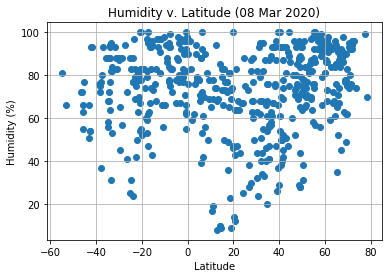

In [200]:
fig = plot_metric_against_latitude(2, city_weather, "Humidity", "Humidity (%)", "Humidity")

In [201]:
plt.close(fig)

#### Latitude vs. Cloudiness Plot

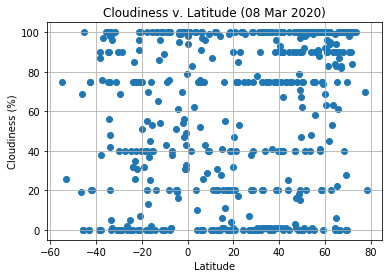

In [202]:
fig = plot_metric_against_latitude(3, city_weather, "Cloudiness", "Cloudiness (%)", "Cloudiness")

In [203]:
plt.close(fig)

#### Latitude vs. Wind Speed Plot

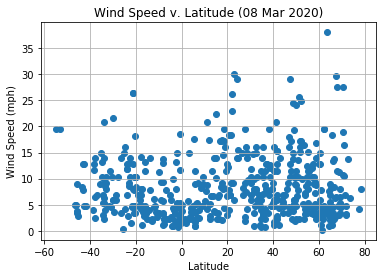

In [204]:
fig = plot_metric_against_latitude(4, city_weather, "Wind_Speed", "Wind Speed (mph)", "Wind Speed")

In [205]:
plt.close(fig)

## Linear Regression

In [ ]:
# OPTIONAL: Create a function to create Linear Regression plots


In [ ]:
# Create Northern and Southern Hemisphere DataFrames


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression